In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix


In [2]:
diabetes_df = pd.read_csv('data/diabetes.csv')
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [4]:
# Shortening the name of DiabetesPedigreeFunction
diabetes_df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

In [5]:
# Checking the proportion of zero values in each of the features 
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = diabetes_df['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_df[diabetes_df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies 0 number of cases 111, percent is 14.45 %
Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


In [6]:
# Changing the zero values to the mean values 
diabetes_mean = diabetes_df[zero_features].mean()
diabetes_df[zero_features]=diabetes_df[zero_features].replace(0, diabetes_mean)

In [7]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df.iloc[:,-1]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
diabetes_df.to_csv('diabetes_clean.csv', index = False)

In [10]:
from pycaret.classification import *

clf1 = setup(data = diabetes_df, 
             target = 'Outcome',
             preprocess = False,
             silent = True)

,Description,Value
0,session_id,4099
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Transformed Train Set,"(537, 8)"
9,Transformed Test Set,"(231, 8)"


In [11]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [12]:
top5 = compare_models(sort='AUC',
                      n_select = 5
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7786,0.8426,0.5661,0.7300,0.6323,0.4781,0.4894,0.0030
lr,Logistic Regression,0.7805,0.8407,0.5716,0.7309,0.6370,0.4834,0.4939,0.3330
et,Extra Trees Classifier,0.7821,0.8398,0.5874,0.7246,0.6417,0.4890,0.4989,0.0300
gbc,Gradient Boosting Classifier,0.7692,0.8342,0.6211,0.6802,0.6442,0.4745,0.4798,0.0140
rf,Random Forest Classifier,0.7840,0.8303,0.5933,0.7315,0.6466,0.4948,0.5060,0.0330
lightgbm,Light Gradient Boosting Machine,0.7617,0.8174,0.6319,0.6642,0.6432,0.4650,0.4689,0.0760
qda,Quadratic Discriminant Analysis,0.7599,0.8121,0.5822,0.6781,0.6138,0.4435,0.4545,0.0030
nb,Naive Bayes,0.7542,0.8104,0.5886,0.6609,0.6117,0.4352,0.4442,0.0030
ada,Ada Boost Classifier,0.7656,0.8101,0.5895,0.6861,0.6277,0.4591,0.4663,0.0130
knn,K Neighbors Classifier,0.7487,0.7633,0.5874,0.6405,0.6095,0.4256,0.4286,0.2260


In [13]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7037,0.8009,0.4444,0.5714,0.5000,0.2941,0.2988
1,0.8519,0.9460,0.7222,0.8125,0.7647,0.6571,0.6596
2,0.7222,0.7762,0.6111,0.5789,0.5946,0.3836,0.3839
3,0.7963,0.8843,0.5556,0.7692,0.6452,0.5075,0.5207
4,0.8148,0.9259,0.5556,0.8333,0.6667,0.5455,0.5669
5,0.7037,0.7654,0.5263,0.5882,0.5556,0.3344,0.3355
6,0.7222,0.7684,0.6316,0.6000,0.6154,0.3982,0.3985
7,0.8868,0.9365,0.7778,0.8750,0.8235,0.7406,0.7434
8,0.7358,0.7762,0.5556,0.6250,0.5882,0.3948,0.3963


In [14]:
#prediction
pred = stack_model.predict(X_test)
pred_proba = stack_model.predict_proba(X_test)[:,1]
#Accuracy
confusion_stack = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.7965, precision: 0.7200, recall: 0.6750,    F1: 0.6968, AUC:0.8648


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

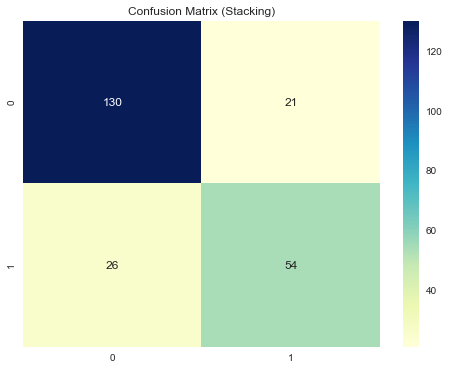

In [15]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_stack, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

In [16]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.8194,0.5000,0.6923,0.5806,0.4179,0.4288
1,0.8889,0.9522,0.8333,0.8333,0.8333,0.7500,0.7500
2,0.6852,0.7855,0.5556,0.5263,0.5405,0.3014,0.3016
3,0.7963,0.8549,0.6111,0.7333,0.6667,0.5217,0.5262
4,0.8333,0.9306,0.5556,0.9091,0.6897,0.5846,0.6177
5,0.7407,0.7789,0.5789,0.6471,0.6111,0.4176,0.4190
6,0.7407,0.7639,0.5789,0.6471,0.6111,0.4176,0.4190
7,0.8868,0.9397,0.8333,0.8333,0.8333,0.7476,0.7476
8,0.7170,0.8222,0.5556,0.5882,0.5714,0.3604,0.3607


In [17]:
#prediction
pred = blend_soft.predict(X_test)
pred_proba = blend_soft.predict_proba(X_test)[:,1]
#Accuracy
confusion_soft = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.8874, precision: 0.8375, recall: 0.8375,    F1: 0.8375, AUC:0.9574


Text(0.5, 1.0, 'Confusion Matrix (Soft Blending)')

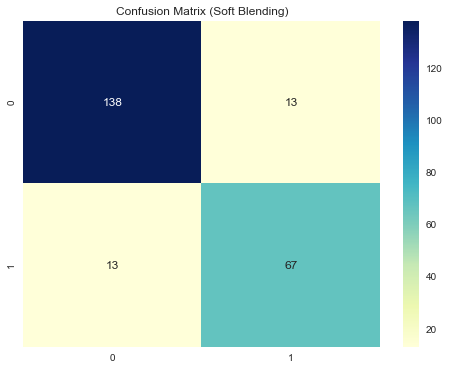

In [18]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_soft, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Soft Blending)')

In [19]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.0000,0.5000,0.6923,0.5806,0.4179,0.4288
1,0.8889,0.0000,0.8333,0.8333,0.8333,0.7500,0.7500
2,0.6667,0.0000,0.5000,0.5000,0.5000,0.2500,0.2500
3,0.8148,0.0000,0.6111,0.7857,0.6875,0.5588,0.5677
4,0.8148,0.0000,0.5556,0.8333,0.6667,0.5455,0.5669
5,0.7222,0.0000,0.5263,0.6250,0.5714,0.3682,0.3711
6,0.7407,0.0000,0.6316,0.6316,0.6316,0.4316,0.4316
7,0.8868,0.0000,0.8333,0.8333,0.8333,0.7476,0.7476
8,0.7170,0.0000,0.5556,0.5882,0.5714,0.3604,0.3607


In [20]:
#prediction
pred = blend_hard.predict(X_test)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.8745, precision: 0.8312, recall: 0.8000,F1: 0.8153


Text(0.5, 1.0, 'Confusion Matrix (Hard Blending)')

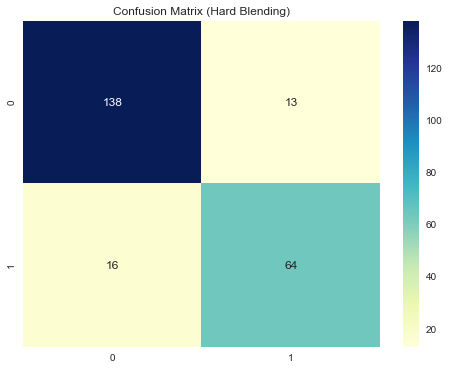

In [21]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

In [22]:
cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7407,0.8164,0.4444,0.6667,0.5333,0.3636,0.3780
1,0.8889,0.9552,0.8333,0.8333,0.8333,0.7500,0.7500
2,0.7037,0.7901,0.5556,0.5556,0.5556,0.3333,0.3333
3,0.7963,0.8611,0.5556,0.7692,0.6452,0.5075,0.5207
4,0.8148,0.9275,0.5000,0.9000,0.6429,0.5312,0.5731
5,0.7407,0.7744,0.5789,0.6471,0.6111,0.4176,0.4190
6,0.7593,0.7774,0.6316,0.6667,0.6486,0.4658,0.4661
7,0.9057,0.9397,0.8333,0.8824,0.8571,0.7868,0.7875
8,0.7170,0.8175,0.5556,0.5882,0.5714,0.3604,0.3607


In [23]:
final_model = finalize_model(cali_model)

In [24]:
#prediction
pred = final_model.predict(X_test)
#Accuracy
final_model = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.9221, precision: 0.9189, recall: 0.8500,F1: 0.8831


Text(0.5, 1.0, 'Confusion Matrix (final_model)')

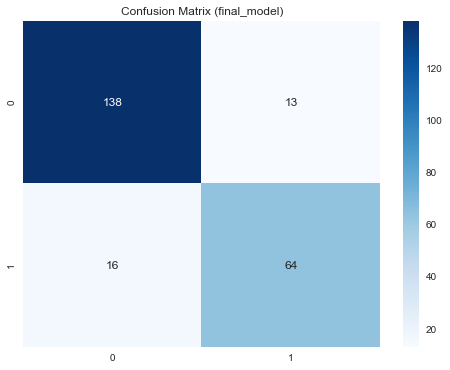

In [25]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'Blues',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')